# AntiVirus Demo

I will test 6 different machine learning classification algorithms to detecting before selecting the one with the highest probability of successful detections. 

The classifiers I will be testing will be:

+ Decision Tree.
+ Random Forest.
+ Gradient Boosting. 
+ Adaboost.
+ Extra Trees Classifier
+ GNB.

The algorithms will be training on a csv file dataset containing 138045 PE files. 

I will then test a variety of PE files to see whether the winning algorithm is successful with new data

# Feature Extraction

Machine learning only uses integers and floats as features for detection but most PE file parameters are integers which will be enough for our detection model. I used a compiled CSV file containing a list of extracted features from llSourcell  


The list of feature extracted : 

Name, md5, Machine, SizeOfOptionalHeader, Characteristics, MajorLinkerVersion, MinorLinkerVersion, SizeOfCode, SizeOfInitializedData, SizeOfUninitializedData, AddressOfEntryPoint, BaseOfCode, BaseOfData, ImageBase, SectionAlignment, FileAlignment, MajorOperatingSystemVersion, MinorOperatingSystemVersion, MajorImageVersion, MinorImageVersion, MajorSubsystemVersion, MinorSubsystemVersion, SizeOfImage, SizeOfHeaders, CheckSum, Subsystem, DllCharacteristics, SizeOfStackReserve, SizeOfStackCommit, SizeOfHeapReserve, SizeOfHeapCommit, LoaderFlags, NumberOfRvaAndSizes, SectionsNb, SectionsMeanEntropy, SectionsMinEntropy, SectionsMaxEntropy, SectionsMeanRawsize, SectionsMinRawsize, SectionMaxRawsize, SectionsMeanVirtualsize, SectionsMinVirtualsize, SectionMaxVirtualsize, ImportsNbDLL, ImportsNb, ImportsNbOrdinal, ExportNb, ResourcesNb, ResourcesMeanEntropy, ResourcesMinEntropy, ResourcesMaxEntropy, ResourcesMeanSize, ResourcesMinSize, ResourcesMaxSize, LoadConfigurationSize, VersionInformationSize.


Regarding the dataset, we need to have an important number of both legitimate and malicious file:

For legitimate file, the dataset contains all the Windows binaries (exe + dll) from Windows 2008, Windows XP and Windows 7 32 and 64 bits, so exactly 41323 binaries. It is not a perfect dataset as there is only Microsoft binaries and not binaries from application which could have different properties, but  it will be enough for testing. 
    
Regarding malware, part of Virus Share collection was used by downloading one archive (the 134th) and kept only PE files (96724 different files).



# Feature Selection

For feature selection we need to reduce the number of features to a smaller set of the most relevant, differentiating malicious binaries from legitimate. To do this we will use Pandas, Sklearn and Numpy libraries.

In [2]:
import pandas as pd
import numpy as np
import pickle

import sklearn.ensemble as ske
from sklearn import cross_validation, tree, linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

"""Import dataset and drop irrelivant x columns. Data set contains a list of of portable 
executable files labeled as legit(1) or malicious (0)"""

data = pd.read_csv('data.csv', sep='|')
legit_binaries = data[0:41323].drop(['legitimate'], axis=1)
malicious_binaries = data[41323::].drop(['legitimate'], axis=1)



C:\Users\andre\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


To check manually for differences we can check the different values and see if there is a difference between the two by taking the FileAlignment parameter and check its values. 

In [3]:
legit_binaries['FileAlignment'].value_counts()


512      36843
4096      4313
128         89
32          40
65536       36
16           2
Name: FileAlignment, dtype: int64

In [4]:
malicious_binaries['FileAlignment'].value_counts()

512     94612
4096     2074
128        18
1024       15
64          2
32          1
16          1
2048        1
Name: FileAlignment, dtype: int64

There is not much difference in the values and wouldn't make a good feature to select from. However other features such as the max entropy of sections are. We can show this by visualising a histogram. 

C:\Users\andre\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\andre\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


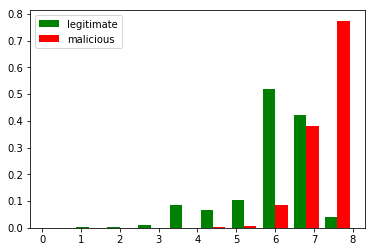

In [5]:
import matplotlib.pyplot as plt

plt.hist([legit_binaries['SectionsMaxEntropy'], malicious_binaries['SectionsMaxEntropy']], range=[0,8],
         normed=True, color=["green", "red"],label=["legitimate", "malicious"])
plt.legend()
plt.show()

This shows that the malicious files have higher entropy than those of legitimate which is a good start for feature selection.

However, the Scikit library has a more efficient way of selecting fetaures to reduce dimentionality 

In [8]:
"""Feature selection using Trees Classifier: we need to check which of the data is important 
for the classifier. Using an extra trees classifier.It fits randomised decision trees to subsets of our data""" 

fsel = ske.ExtraTreesClassifier().fit(X, y)
model = SelectFromModel(fsel, prefit=True)
X_new = model.transform(X)
nb_features = X_new.shape[1]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_new, y ,test_size=0.2)

features = []

print('%i features identified as important:' % nb_features)

#sort features 
indices = np.argsort(fsel.feature_importances_)[::-1][:nb_features]
for f in range(nb_features):
    print("%d. feature %s (%f)" % (f + 1, data.columns[2+indices[f]], fsel.feature_importances_[indices[f]]))

# XXX : take care of the feature order
for f in sorted(np.argsort(fsel.feature_importances_)[::-1][:nb_features]):
    features.append(data.columns[2+f])


13 features identified as important:
1. feature Characteristics (0.173984)
2. feature Machine (0.084511)
3. feature ImageBase (0.080936)
4. feature DllCharacteristics (0.065589)
5. feature ResourcesMaxEntropy (0.063370)
6. feature VersionInformationSize (0.058164)
7. feature MajorSubsystemVersion (0.057989)
8. feature ResourcesMinEntropy (0.056979)
9. feature SectionsMaxEntropy (0.049482)
10. feature SizeOfOptionalHeader (0.047643)
11. feature Subsystem (0.043562)
12. feature MajorOperatingSystemVersion (0.030425)
13. feature SectionsMinEntropy (0.021421)


So in this case 13 features were regarded as important. 

# Classification Selection

So to decide model to use a simple option is test a variety using their default parameters and use the one wone with the best success rate. This is judged by the lowest false positive and false negative rate. As mentioned earlier, we will be testing: Decision Tree,
Random Forest, 
Gradient Boosting, Extra Trees Classifier,  
Adaboost and
GNB.


In [17]:
"""We need to create an array of models: need to test each algorithm 
Algorithm comparison"""

algorithms = {
        "DecisionTree": tree.DecisionTreeClassifier(max_depth=10),
        "RandomForest": ske.RandomForestClassifier(n_estimators=50),
        "ExtraTreesClassifier": ske.ExtraTreesClassifier(n_estimators=50),
        "GradientBoosting": ske.GradientBoostingClassifier(n_estimators=50),
        "AdaBoost": ske.AdaBoostClassifier(n_estimators=100),
        "GNB": GaussianNB()
    }

results = {}
print("\nNow testing algorithms")
for algo in algorithms:
    clf = algorithms[algo]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("%s : %f %%" % (algo, score*100))
    results[algo] = score

winner = max(results, key=results.get)
print('\nWinner algorithm is %s with a %f %% success' % (winner, results[winner]*100))



# Identify false and true positive rates
clf = algorithms[winner]
res = clf.predict(X_test)
mt = confusion_matrix(y_test, res)
print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
print('False negative rate : %f %%' % ( (mt[1][0] / float(sum(mt[1]))*100)))


Now testing algorithms
DecisionTree : 99.090909 %
RandomForest : 99.424122 %
ExtraTreesClassifier : 99.413256 %
GradientBoosting : 98.797537 %
AdaBoost : 98.649040 %
GNB : 70.079681 %

Winner algorithm is RandomForest with a 99.424122 % success
False positive rate : 0.475477 %
False negative rate : 0.811040 %


So as we can see the RandomForest algorithm worked the best with fp/fn score of: 

+ False positive rate : 0.475477 %
+ False negative rate : 0.811040 %

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

<img src="random forest.jpg" width="400">


Random decision forests correct for decision trees' habit of overfitting to their training set so the high success rate maybe due to overfitting. Overfitting is "the production of an analysis that corresponds too closely or exactly to a particular set of data, and may therefore fail to fit additional data or predict future observations reliably". One way to test this is by testing it on newer malicious PE files another solution would be to retrain the model periodically on new data but this somewhat defeats the point of AI. 

# Test Classification Selection

So to test the algoritms on new data we need to save the object and feature list.

In [11]:
# Save the algorithm and the feature list for later predictions
print('Saving algorithm and feature list in classifier directory...')
joblib.dump(algorithms[winner], 'classifier/classifier.pkl')
open('classifier/features.pkl', 'wb').write(pickle.dumps(features))
print('Saved')


Saving algorithm and feature list in classifier directory...
Saved


Then we need to implement a function to load the feature list, extract the PE featues and then predict whether the file is legitimate or not. To do this I used a checkpe.py function to do so which you can find in the file folder. 

To run the function: open a command line and enter:

```python checkpe.py nameoffile.pe```

Here is a snapshot from when I tested it on some legitimate and malicious files. 

<img src="test.png" width="1000">

As you can see it worked well enough on these simple .dll, .sys, .exe files. However, I have to stress this model will only work on PE features. 


# Conclusion

Whilst the accuracy is better than some products out there it still falls short and this has to do with the differences between specitivity, specificity, recall and precision: 


    Sensitivity: Of all labeled positive for containing malware, how many were correctly predicted?
    Specificity: Of all labeled negative for containing malware, how many were correctly predicted?
    
    Recall: Of all the files containing malware, how many did we predict as containing?
    Precision: Of all the files containing malware, how many actually had malware?
    
    False Positive: the proportion of events badly identified as positive over the total number of negatives
    False Negative: the proportion of events badly identified as negative over the total number of positives
    

<img src="confusion_matrix_1.png" width="400">

So the problem is that although 99.4% accuracy is high you cannot just consider the malicious over legitimate ratio per the amount of alerts the programm generates. If we look at the confusion matrix below we can see that out of 27610 identified features 92 came out as false negative which is a substantial amount to get through. 

It may be possible to make a neural net that could predict more efficiently through backpropogation but that would require 10's of 1000's of files to test on.  

In [23]:
from sklearn.metrics import confusion_matrix

mt = confusion_matrix(y_test, res)

print (mt)

[[19257    92]
 [   67  8194]]
